# Notebook for regridding using xarray to compare WRF HIST and GridRad MESH

### Read in geometry and apply coarsen to WRF lats/lons:

In [1]:
import xarray as xr

geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc") #Open WRF lat/lon coords file

coarse_geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean() #Find mean lat/lon of grid runs: averaging over 20 pixels is
                                                                                                    #roughly equivalent to 75 km (20 * 3.75 km = 75)

### New dimensions of lat/lon data are now 44 x 69 after averaging across 20 pixels (mean lat/lon of the 20th pixel run, or centroid)

## Use WRF HIST data to validate that this method upscales original data to ~75 x 75 km grid

In [2]:
wrf_hist = xr.open_mfdataset('/home/scratch/ahaberlie/AFWA_HAIL/HIST/*/*.nc') #Open WRF daily max file
wrf_hist

<xarray.Dataset>
Dimensions:     (Time: 131007, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-10-01 ... 2005-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 dask.array<chunksize=(24, 899, 1399), meta=np.ndarray>
Attributes: (12/93)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    file_count:                      24
    first_file:                      /gpfs/csfs1/univ/unid0001/historical/199...
    last_file:                       /gpfs/csfs1/univ/unid0001/historical/199...
    first_time:                      1990-10-01T00:00:00.000000000
    last_time:                       1990-10-01T23:00:00.000000000
    sim:                             historical

## Open gridrad MESH dataset for validation against WRF HIST

In [3]:
gridrad = xr.open_mfdataset('/home/scratch/gridrad_mesh/gridrad/*/*/*.nc')
gridrad

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 201624)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1995-01-01 ... 2017-12-31T23:00:00
Data variables:
    SHI        (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

## Coarsen GridRad geography (lats/lons have already been tested to approximate a 75 km grid)

In [4]:
coarse_gridrad_geog = gridrad[['Latitude', 'Longitude']].coarsen(Latitude=32, Longitude=49, boundary='trim').mean()

### Slice gridrad dataset to only use 1995 - 2005 to create a 10-year climatology

In [5]:
gridrad_test = gridrad.sel(time=slice('1995','2005'))
gridrad_test

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 96432)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1995-01-01 ... 2005-12-31T23:00:00
Data variables:
    SHI        (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) float32 dask.array<chunksize=(24, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

## Resample to convective daily max

In [6]:
wrf_daily_max = wrf_hist.resample(Time='24H', base=12).max()
wrf_daily_max #Returns 5479 days (4 leap days)

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>
Attributes: (12/93)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    file_count:                      24
    first_file:                      /gpfs/csfs1/univ/unid0001/historical/199...
    last_file:                       /gpfs/csfs1/univ/unid0001/historical/199...
    first_time:                      1990-10-01T00:00:00.000000000
    last_time:                       1990-10-01T23:00:00.000000000
    sim:                             historical

In [7]:
gridrad_daily_max = gridrad_test.resample(time='24H', base=12).max()
gridrad_daily_max

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 4019)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1994-12-31T12:00:00 ... 2005-12-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

## Pass severe hail threshold (can switch this out for large hail [≥ 4 cm] as well)

In [12]:
sev_hail_days = 1 * (wrf_daily_max >= 0.0254) #Pass day threshold to this variable
sev_hail_days

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>
Attributes: (12/93)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    file_count:                      24
    first_file:                      /gpfs/csfs1/univ/unid0001/historical/199...
    last_file:                       /gpfs/csfs1/univ/unid0001/historical/199...
    first_time:                      1990-10-01T00:00:00.000000000
    last_time:                       1990-10-01T23:00:00.000000000
    sim:                             historical

In [14]:
#sev_hail_days.sel(Time = '05-02-2000').HAIL_MAX2D.plot()

In [9]:
gridrad_sev = 1 * (gridrad_daily_max >= 25.4) #Pass mesh day threshold to this variable
gridrad_sev

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 4019)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1994-12-31T12:00:00 ... 2005-12-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

### Compute hail days to work with later

In [10]:
import dask
import dask.array as da
from dask import delayed
import dask.dataframe as dd
from dask.distributed import Client
dask.config.set({'temporary_directory': '/home/scratch/jgoodin'})
client = Client()
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33164 instead
  warnings.warn(
2023-02-05 16:18:02,902 - distributed.diskutils - INFO - Found stale lock file and directory '/home/scratch/jgoodin/dask-worker-space/worker-otmc69ly', purging
2023-02-05 16:18:02,903 - distributed.diskutils - INFO - Found stale lock file and directory '/home/scratch/jgoodin/dask-worker-space/worker-zm33zodj', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33164/status,
Dashboard: http://127.0.0.1:33164/status,Workers: 8
Total threads: 64,Total memory: 755.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35906,Workers: 8
Dashboard: http://127.0.0.1:33164/status,Total threads: 64
Started: Just now,Total memory: 755.66 GiB
Comm: tcp://127.0.0.1:42926,Total threads: 8
Dashboard: http://127.0.0.1:35741/status,Memory: 94.46 GiB
Nanny: tcp://127.0.0.1:46050,


In [15]:
sev_hail_days = sev_hail_days.compute()

In [ ]:
#gridrad_sev = gridrad_sev.compute()

## Groupby year and sum along 'Time' axis to find mean annual days

In [16]:
wrf_annual = sev_hail_days.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year')

In [17]:
wrf_annual

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 0.0 0.0 0.0 ... 0.125 0.125

In [18]:
gridrad_annual = gridrad_sev.groupby('time.year').sum(dim = 'time').mean(dim = 'year')

In [19]:
gridrad_annual

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
Data variables:
    SHI        (Latitude, Longitude) float64 dask.array<chunksize=(1201, 2301), meta=np.ndarray>
    MESH75     (Latitude, Longitude) float64 dask.array<chunksize=(1201, 2301), meta=np.ndarray>
    MESH95     (Latitude, Longitude) float64 dask.array<chunksize=(1201, 2301), meta=np.ndarray>

In [20]:
gridrad_annual.to_netcdf('/home/scratch/jgoodin/gridrad_mean_annual_sev_hail_days_1995-2005.nc')

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-

In [22]:
gridrad_annual_sev_days = xr.open_dataset('/home/scratch/jgoodin/gridrad_mean_annual_sev_hail_days_1995-2005.nc')

In [23]:
gridrad_annual_sev_days

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
Data variables:
    SHI        (Latitude, Longitude) float64 ...
    MESH75     (Latitude, Longitude) float64 ...
    MESH95     (Latitude, Longitude) float64 ...

In [56]:
gridrad_4cm = 1 * (gridrad_daily_max >= 40) #Pass mesh day threshold to this variable
gridrad_4cm

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 4019)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1994-12-31T12:00:00 ... 2005-12-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

In [57]:
gridrad_4cm_annual = gridrad_4cm.groupby('time.year').sum(dim = 'time').mean(dim = 'year')

In [58]:
gridrad_4cm_annual.to_netcdf('/home/scratch/jgoodin/gridrad_mean_annual_4cm_hail_days_1995-2005.nc')

In [59]:
gridad_4cm_days = xr.open_dataset('/home/scratch/jgoodin/gridrad_mean_annual_4cm_hail_days_1995-2005.nc')

## Groupby season to find seasonal sev hail days

In [ ]:
seasonal_max = sev_hail_days.groupby('Time.season')
seasonal_max

In [44]:
gridrad_seasonal = gridrad_sev.groupby('time.season')
gridrad_seasonal

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

### Select by season for plotting (and sum and take mean for mean seasonal grid days)

In [ ]:
"""
wrf_DJF = seasonal_max['DJF']
wrf_MAM = seasonal_max['MAM']
wrf_JJA = seasonal_max['JJA']
wrf_SON = seasonal_max['SON']
"""

In [ ]:
"""
mean_wrf_DJF = wrf_DJF.sum(dim = 'Time')
mean_wrf_MAM = wrf_MAM.sum(dim = 'Time')
mean_wrf_JJA = wrf_JJA.sum(dim = 'Time')
mean_wrf_SON = wrf_SON.sum(dim = 'Time')
"""

In [ ]:
"""
mean_DJF_plot = mean_wrf_DJF / 15
mean_MAM_plot = mean_wrf_MAM / 15
mean_JJA_plot = mean_wrf_JJA / 15
mean_SON_plot = mean_wrf_SON / 15
"""

In [ ]:
#wrf_JJA #Returns # of days in 3-month season x 899 x 1399

In [45]:
gridrad_DJF = gridrad_seasonal['DJF']
gridrad_MAM = gridrad_seasonal['MAM']
gridrad_JJA = gridrad_seasonal['JJA']
gridrad_SON = gridrad_seasonal['SON']

In [46]:
gridrad_MAM

<xarray.Dataset>
Dimensions:    (Longitude: 2301, Latitude: 1201, time: 1012)
Coordinates:
  * Longitude  (Longitude) float32 245.0 245.0 245.0 245.1 ... 291.0 291.0 291.0
  * Latitude   (Latitude) float32 25.0 25.02 25.04 25.06 ... 48.96 48.98 49.0
  * time       (time) datetime64[ns] 1995-03-01T12:00:00 ... 2005-05-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 1201, 2301), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

In [47]:
mean_gridrad_DJF = gridrad_DJF.sum(dim = 'time')
mean_gridrad_MAM = gridrad_MAM.sum(dim = 'time')
mean_gridrad_JJA = gridrad_JJA.sum(dim = 'time')
mean_gridrad_SON = gridrad_SON.sum(dim = 'time')

In [48]:
mean_gridrad_DJF_plot = mean_gridrad_DJF / 10
mean_gridrad_MAM_plot = mean_gridrad_MAM / 10
mean_gridrad_JJA_plot = mean_gridrad_JJA / 10
mean_gridrad_SON_plot = mean_gridrad_SON / 10

# Coarsen the data

### NOTE: must coarsen MESH data to different number of pixels since resolution isn't the same- both must be (44 x 69)

In [ ]:
hail_day_coarse = sev_hail_days.coarsen(south_north=20, west_east=20, boundary='trim').max()

In [ ]:
hail_day_coarse.HAIL_MAX2D.shape #Make sure new lats/lons are (44 x 69)

In [24]:
wrf_annual_coarse = wrf_annual.coarsen(south_north=20, west_east=20, boundary='trim').max()

In [ ]:
wrf_DJF_coarse = wrf_DJF.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_MAM_coarse = wrf_MAM.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_JJA_coarse = wrf_JJA.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_SON_coarse = wrf_SON.coarsen(south_north=20, west_east=20, boundary='trim').max()

In [ ]:
wrf_mean_DJF_coarse = mean_DJF_plot.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_mean_MAM_coarse = mean_MAM_plot.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_mean_JJA_coarse = mean_JJA_plot.coarsen(south_north=20, west_east=20, boundary='trim').max()
wrf_mean_SON_coarse = mean_SON_plot.coarsen(south_north=20, west_east=20, boundary='trim').max()

### Coarsen gridrad MESH data (will require different number of pixels to be passed)

#### NOTE: might have to be an approximation for gridrad

In [36]:
gridrad_coarse = gridrad_sev.coarsen(Longitude=49, Latitude=32, boundary='trim').max()

In [37]:
gridrad_coarse

<xarray.Dataset>
Dimensions:    (time: 4019, Latitude: 37, Longitude: 46)
Coordinates:
  * Longitude  (Longitude) float32 245.5 246.5 247.4 248.4 ... 287.6 288.6 289.6
  * Latitude   (Latitude) float32 25.31 25.95 26.59 27.23 ... 47.07 47.71 48.35
  * time       (time) datetime64[ns] 1994-12-31T12:00:00 ... 2005-12-31T12:00:00
Data variables:
    SHI        (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 37, 46), meta=np.ndarray>
    MESH75     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 37, 46), meta=np.ndarray>
    MESH95     (time, Latitude, Longitude) int64 dask.array<chunksize=(1, 37, 46), meta=np.ndarray>
Attributes:
    Name:                GridRad Derived Variable
    Description:         Reflectivity-estimated hail sizes
    Algorithm_version:   3_1
    File_creation_date:  2019-04-05 14:13:10Z
    Authors:             Cameron R. Homeyer, School of Meteorology, Universit...

In [60]:
gridrad_annual_coarse = gridad_4cm_days.coarsen(Longitude=49, Latitude=32, boundary='trim').max()

In [61]:
gridrad_annual_coarse

<xarray.Dataset>
Dimensions:    (Latitude: 37, Longitude: 46)
Coordinates:
  * Longitude  (Longitude) float32 245.5 246.5 247.4 248.4 ... 287.6 288.6 289.6
  * Latitude   (Latitude) float32 25.31 25.95 26.59 27.23 ... 47.07 47.71 48.35
Data variables:
    SHI        (Latitude, Longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MESH75     (Latitude, Longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MESH95     (Latitude, Longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
gridrad_coarse.Longitude.shape

In [ ]:
gridrad_DJF_coarse = gridrad_DJF.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_MAM_coarse = gridrad_MAM.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_JJA_coarse = gridrad_JJA.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_SON_coarse = gridrad_SON.coarsen(Latitude=32, Longitude=49, boundary='trim').max()

In [49]:
gridrad_mean_DJF_coarse = mean_gridrad_DJF_plot.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_mean_MAM_coarse = mean_gridrad_MAM_plot.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_mean_JJA_coarse = mean_gridrad_JJA_plot.coarsen(Latitude=32, Longitude=49, boundary='trim').max()
gridrad_mean_SON_coarse = mean_gridrad_SON_plot.coarsen(Latitude=32, Longitude=49, boundary='trim').max()

## Sum along 'Time' dimension (simulation year) to get hail day count for each grid

### NOTE: this next part is used to find annual days. This is a cumulative sum

In [ ]:
annual_sum = hail_day_coarse.sum(dim = 'Time')

In [ ]:
annual_sum

In [ ]:
wrf_DJF_sum = wrf_DJF_coarse.sum(dim = 'Time')
wrf_MAM_sum = wrf_MAM_coarse.sum(dim = 'Time')
wrf_JJA_sum = wrf_JJA_coarse.sum(dim = 'Time')
wrf_SON_sum = wrf_SON_coarse.sum(dim = 'Time')

In [38]:
gridrad_sum = gridrad_coarse.sum(dim = 'time')

In [39]:
gridrad_sum

<xarray.Dataset>
Dimensions:    (Latitude: 37, Longitude: 46)
Coordinates:
  * Longitude  (Longitude) float32 245.5 246.5 247.4 248.4 ... 287.6 288.6 289.6
  * Latitude   (Latitude) float32 25.31 25.95 26.59 27.23 ... 47.07 47.71 48.35
Data variables:
    SHI        (Latitude, Longitude) int64 dask.array<chunksize=(37, 46), meta=np.ndarray>
    MESH75     (Latitude, Longitude) int64 dask.array<chunksize=(37, 46), meta=np.ndarray>
    MESH95     (Latitude, Longitude) int64 dask.array<chunksize=(37, 46), meta=np.ndarray>

In [ ]:
#gridrad_sum.MESH95.max()

In [ ]:
gridrad_DJF_sum = gridrad_DJF_coarse.sum(dim = 'time')
gridrad_MAM_sum = gridrad_MAM_coarse.sum(dim = 'time')
gridrad_JJA_sum = gridrad_JJA_coarse.sum(dim = 'time')
gridrad_SON_sum = gridrad_SON_coarse.sum(dim = 'time')

### Divide by 15 (10 for gridrad mesh subset) to get mean annual statistic

In [ ]:
annual_stat = annual_sum / 15
wrf_DJF_stat = wrf_DJF_sum / 15
wrf_MAM_stat = wrf_MAM_sum / 15
wrf_JJA_stat = wrf_JJA_sum / 15
wrf_SON_stat = wrf_SON_sum / 15

In [40]:
gridrad_annual_stat = gridrad_sum / 10
#gridrad_DJF_stat = gridrad_DJF_sum / 10
#gridrad_MAM_stat = gridrad_MAM_sum / 10
#gridrad_JJA_stat = gridrad_JJA_sum / 10
#gridrad_SON_stat = gridrad_SON_sum / 10

### Select HAIL_MAX2D (MESH95) variable to create plottable 2D array

In [ ]:
annual_plot = annual_stat.HAIL_MAX2D
wrf_DJF_stat_plot = wrf_DJF_stat.HAIL_MAX2D
wrf_MAM_stat_plot = wrf_MAM_stat.HAIL_MAX2D #**These are plotting variables**
wrf_JJA_stat_plot = wrf_JJA_stat.HAIL_MAX2D
wrf_SON_stat_plot = wrf_SON_stat.HAIL_MAX2D

In [ ]:
annual_plot

In [41]:
gridrad_annual_plot = gridrad_annual_stat.MESH95
#gridrad_DJF_stat_plot = gridrad_DJF_stat.MESH95
#gridrad_MAM_stat_plot = gridrad_MAM_stat.MESH95 #**These are plotting variables**
#gridrad_JJA_stat_plot = gridrad_JJA_stat.MESH95
#gridrad_SON_stat_plot = gridrad_SON_stat.MESH95

In [ ]:
gridrad_stat_plot.max()

## Find deltas between WRF HIST and Gridrad MESH

In [34]:
#annual_delta = annual_stat_plot - gridrad_stat_plot
mean_annual_delta = wrf_annual_coarse.HAIL_MAX2D - gridrad_annual_coarse.MESH95
#DJF_delta = wrf_DJF_stat_plot - gridrad_DJF_stat_plot
#MAM_delta = wrf_MAM_stat_plot - gridrad_MAM_stat_plot #**These are also plotting variables**
#JJA_delta = wrf_JJA_stat_plot - gridrad_JJA_stat_plot
#SON_delta = wrf_SON_stat_plot - gridrad_SON_stat_plot

## Plot on map of CONUS

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


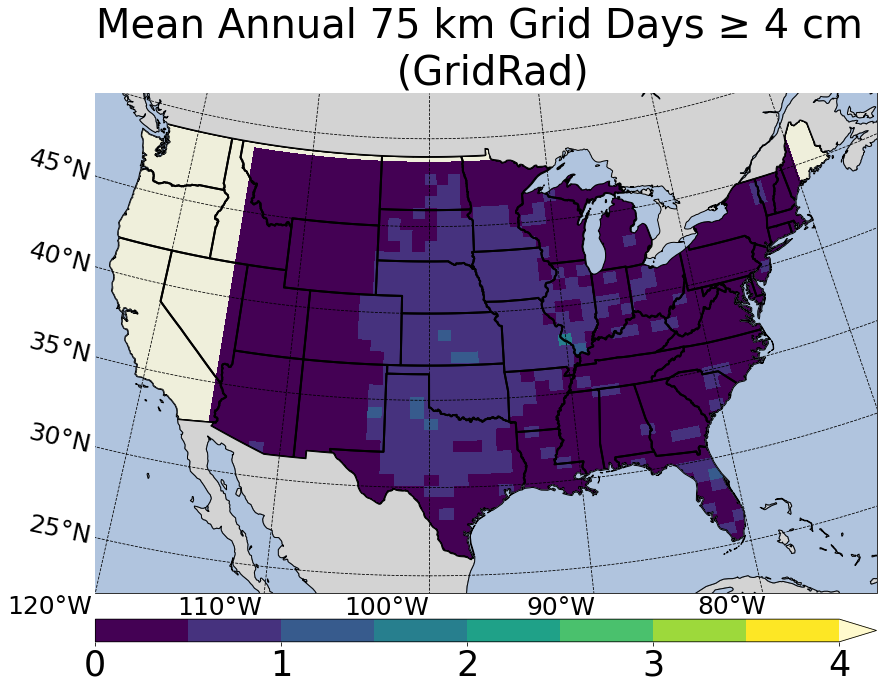

In [63]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .04], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.set_extent([240,287,22,50])
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth = 2) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none', linewidth = 2) #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
            
cmap = cm.get_cmap('viridis')
#cmap.set_over('lemonchiffon')
levels = np.arange(0, 4.5, 0.5)

mmp = ax.pcolormesh(coarse_gridrad_geog['Longitude'].values, coarse_gridrad_geog['Latitude'].values, gridrad_annual_coarse.MESH95, vmax = 4.5, 
              shading='nearest', transform=ccrs.PlateCarree(), cmap=cmap, vmin=levels[1], norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, 
                                                                                                                                    clip=False)) #alpha=0.5)

gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dashed", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 25, 'rotation': 0}
gls.xpadding = 15.0
gls.ylabel_style = {'size': 25}
plt.title("Mean Annual 75 km Grid Days ≥ 4 cm \n (GridRad)", fontsize = 40)
ax2 = plt.subplot(gs1[1, 0]) 
#bounds = [0, 10, 20, 30, 40, 50]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(mmp, cax = ax2, ticks = [0, 1, 2, 3, 4], orientation = 'horizontal', extend = 'max')
#cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 35)
plt.subplots_adjust(bottom=0.05)
#plt.tight_layout()
plt.savefig('/home/scratch/jgoodin/compare_wrf_mesh/use_these_figures/gridrad_mean_annual_75km_4cm_hail_days_gridlines.png') #**Make sure to save results to png!**